In [1]:
from ultralytics import YOLO
import cv2
from calibration.calibrate_camera import undistort_image, find_homography, bbox_coordinates_to_world_coordinates, load_coefficients, plot_corrected_image
import matplotlib.pyplot as plt
from tictactoe_engine import infer_tic_tac_toe_state, find_best_move, get_cell_center, play
from xarm import version
import numpy as np
from xarm.wrapper import XArmAPI
from robotic_arm.draw import RobotMain
from robotic_arm.calculate_transformation_matrix import calculate_transformation_matrix, apply_inverse_transformation
RobotMain.pprint('xArm-Python-SDK Version:{}'.format(version.__version__))
ARM = XArmAPI('192.168.1.159', baud_checkset=False)
ROBOT = RobotMain(ARM)
points = np.array([(199, 276), (197, 443)])
transformed_points = np.array([(0, 0), (0, 160)])
transformation_matrix = calculate_transformation_matrix(points, transformed_points)



square_size=25
width=10
height=7
ref_plan="/home/fari/Pictures/calibrationcheckerboard/ref_plan.jpg"

mtx, dist =  load_coefficients("calibration/calibration_coefficients.yml")
ref_plan = undistort_image(ref_plan, mtx, dist)
H, _ = find_homography(ref_plan, width, height, square_size)
    


SDK_VERSION: 1.13.14
Transformation Matrix:
 [[   -0.99993   -0.011975      202.29]
 [  -0.011975     0.99993      -273.6]
 [          0           0           1]]
Transformed Point: [     204.26      146.46           1]
Inverse Transformed Point: [         -7         420           1]
[2023-10-27 16:20:23][11] xArm-Python-SDK Version:1.13.14
ROBOT_IP: 192.168.1.159, VERSION: v1.12.2, PROTOCOL: V1, DETAIL: 6,9,LI1006,DL1000,v1.12.2, TYPE1300: [0, 0]
change protocol identifier to 3
[clean_error], xArm is ready to move
[[          0           0]
 [        2.5           0]
 [          5           0]
 [        7.5           0]
 [         10           0]
 [       12.5           0]
 [         15           0]
 [       17.5           0]
 [         20           0]
 [       22.5           0]
 [          0         2.5]
 [        2.5         2.5]
 [          5         2.5]
 [        7.5         2.5]
 [         10         2.5]
 [       12.5         2.5]
 [         15         2.5]
 [       17.5       

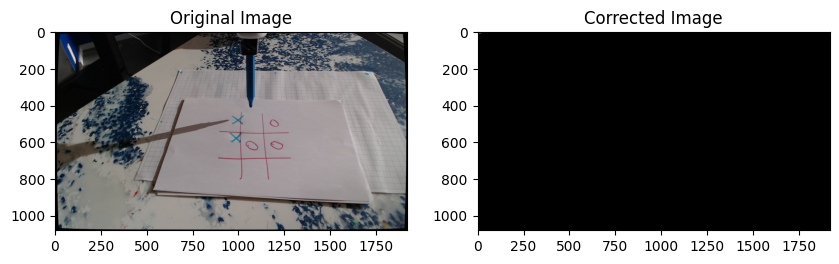

In [2]:

img = undistort_image("test.jpg", mtx, dist)
height, width = img.shape[:2]

plot_corrected_image(img, H, width, height)

In [26]:
MODEL = YOLO("tictactoe/runs/detect/train5/weights/best.pt")
im = undistort_image("test.jpg", mtx, dist)
results = MODEL.predict(source=im, save=True) 



0: 384x640 3 Os, 2 Xs, 1 grid, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict18


In [27]:
def transform_boxes(boxes):
    CLASS_NAMES = ["O", "X", "grid"]
    result = {class_name: [] for class_name in CLASS_NAMES}

    for box in boxes:
        # Extract xywh and class index
        xywh = box.xywh.cpu().numpy()[0]  # Convert to numpy and get the first row and convert to mm
        
        class_idx = int(box.cls.item())
        # Transform to world coordinates
        world_coords = bbox_coordinates_to_world_coordinates(xywh, H)
        world_coords_mm = tuple(coordinate * 10 for coordinate in world_coords )
        # Add to result
        class_name = CLASS_NAMES[class_idx]
        result[class_name].append(world_coords_mm)

    return result
        
# Now, you can use the function as:
output_dict = transform_boxes(results[0].boxes)



In [28]:
grid_state = infer_tic_tac_toe_state(output_dict)
print(grid_state)
# Print the grid
for row in grid_state:
    print('|'.join(row))
    print('---------')

[['X', ' ', 'O'], ['X', 'O', 'O'], [' ', ' ', ' ']]
X| |O
---------
X|O|O
---------
 | | 
---------


In [29]:
move, player_letter = find_best_move(grid_state)
print(f"The best move for player {player_letter } is: {move}")
# Print the grid
for row in grid_state:
    print('|'.join(row))
    print('---------')

The best move for player X is: (2, 0)
X| |O
---------
X|O|O
---------
 | | 
---------


In [31]:
if not move:
        print("fini game over")
else:
    position = get_cell_center(move, output_dict['grid'][0])
print(position)
transformed_point = apply_inverse_transformation(transformation_matrix, [position[0], position[1], 1])

print(transformed_point)

if player_letter== "X":
    ROBOT.draw_x(transformed_point[0], transformed_point[1],  0, 20)
else:
    ROBOT.draw_o(transformed_point[0], transformed_point[1],  0, 20)

    
      


(145.33913462024066, 241.08431998591618)
[     50.784      515.33           1]
[SDK][ERROR][2023-10-27 15:52:14][base.py:373] - - API -> set_position -> code=1, pos=[40.78425660867664, 505.3265693695321, 20.0, 3.490658503988659, 0.0, 0.0], radius=20.0, velo=10.0, acc=1000.0
[SDK][ERROR][2023-10-27 15:52:14][base.py:373] - - API -> set_position -> code=1, pos=[40.78425660867664, 505.3265693695321, 0.0, 3.490658503988659, 0.0, 0.0], radius=20.0, velo=10.0, acc=1000.0
[SDK][ERROR][2023-10-27 15:52:14][base.py:373] - - API -> set_position -> code=1, pos=[60.78425660867664, 525.3265693695321, 0.0, 3.490658503988659, 0.0, 0.0], radius=20.0, velo=10.0, acc=1000.0
[SDK][ERROR][2023-10-27 15:52:14][base.py:373] - - API -> set_position -> code=1, pos=[60.78425660867664, 525.3265693695321, 20.0, 3.490658503988659, 0.0, 0.0], radius=20.0, velo=10.0, acc=1000.0
[SDK][ERROR][2023-10-27 15:52:14][base.py:373] - - API -> set_position -> code=1, pos=[40.78425660867664, 525.3265693695321, 20.0, 3.490658

ControllerError had clean
ControllerError had clean
ControllerError had clean
ControllerError had clean
ControllerError had clean


In [ ]:



print("Transformation Matrix:\n", transformation_matrix)

point_to_transform = np.array([300, 0, 1])  # The point (-8, 270) with an added 1 for homogeneous coordinates
transformed_point = apply_inverse_transformation(transformation_matrix, point_to_transform)
print("Transformed Point:", transformed_point)

#robot_main.draw_x(transformed_point[0], transformed_point[1],  0, 20)
robot_main.draw_o(transformed_point[0], transformed_point[1],  0, 20)

NameError: name 'transformation_matrix' is not defined